## Feature selection for time series data
### Adapted from
- https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

In [15]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as tsaplots
import sklearn.ensemble as sklEN
import sklearn.feature_selection as sklFS

%matplotlib inline

Month
1960-01     6550.0
1960-02     8728.0
1960-03    12026.0
1960-04    14395.0
1960-05    14587.0
Name: Monthly car sales in Quebec 1960-1968, dtype: float64


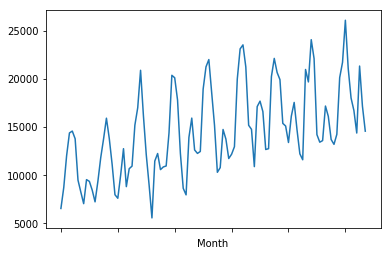

In [16]:
series = pd.Series.from_csv('car-sales.csv', header=0)

print series.head(5)

series.plot()
plt.show()

## Make stationary

- We can see a clear seasonality and increasing trend in the data.

- The trend and seasonality are fixed components that can be added to any prediction we make. They are useful, but need to be removed in order to explore any other systematic signals that can help make predictions.

- A time series with seasonality and trend removed is called stationary.

- To remove the seasonality, we can take the seasonal difference, resulting in a so-called seasonally adjusted time series.

- The period of the seasonality appears to be one year (12 months). The code below calculates the seasonally adjusted time series and saves it to the file “seasonally-adjusted.csv“.

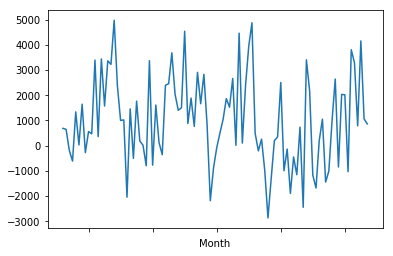

In [17]:
# Shift and subtract. NaN entries are discarded.
differencesSeries = series.diff(12)

differencesSeries.to_csv('seasonally_adjusted.csv')
differencesSeries.plot()
plt.show()

## Autocorrelation Plot

- Traditionally, time series features are selected based on their correlation with the output variable.

- This is called autocorrelation and involves plotting autocorrelation plots, also called a correlogram. These show the correlation of each lagged observation and whether or not the correlation is statistically significant.

- For example, the code below plots the correlogram for all lag variables in the Monthly Car Sales dataset.

- Running the example creates a correlogram, or Autocorrelation Function (ACF) plot, of the data.

- The plot shows lag values along the x-axis and correlation on the y-axis between -1 and 1 for negatively and positively correlated lags respectively.

- The dots above the blue area indicate statistical significance. The correlation of 1 for the lag value of 0 indicates 100% positive correlation of an observation with itself.

- The plot shows significant lag values at 1, 2, 12, and 17 months.

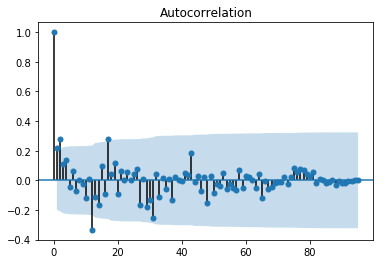

In [18]:
series = pd.Series.from_csv('seasonally_adjusted.csv', header=None)

series.dropna(inplace=True)
tsaplots.plot_acf(series)
plt.show()

## Time Series to Supervised Learning

- We can convert the univariate Monthly Car Sales dataset into a supervised learning problem by taking the lag observation (e.g. t-1) as inputs and using the current observation (t) as the output variable.

- We can do this in Pandas using the shift function to create new columns of shifted observations.

- The example below creates a new time series with 12 months of lag values to predict the current observation.

- The shift of 12 months means that the first 12 rows of data are unusable as they contain NaN values.

In [19]:
series = pd.Series.from_csv('seasonally_adjusted.csv', header=None)
series.dropna(inplace=True)

dataFrame = pd.DataFrame()
for i in range(12, 0, -1):
    dataFrame['t-'+str(i)] = series.shift(i)

dataFrame['t'] = series.values
dataFrame = dataFrame[13:]

dataFrame.to_csv('lags_12months_features.csv', index=False)


## Feature Importance of Lag Variables

- Ensembles of decision trees, like bagged trees, random forest, and extra trees, can be used to calculate a feature importance score.

- This is common in machine learning to estimate the relative usefulness of input features when developing predictive models.

- We can use feature importance to help to estimate the relative importance of contrived input features for time series forecasting.

- This is important because we can contrive not only the lag observation features above, but also features based on the timestamp of observations, rolling statistics, and much more. Feature importance is one method to help sort out what might be more useful in when modeling.

- The example below loads the supervised learning view of the dataset created in the previous section, fits a random forest model (RandomForestRegressor), and summarizes the relative feature importance scores for each of the 12 lag observations.

- A large-ish number of trees is used to ensure the scores are somewhat stable. Additionally, the random number seed is initialized to ensure that the same result is achieved each time the code is run.

- Running the example first prints the importance scores of the lagged observations. The scores are then plotted as a bar graph.

- The plot shows the high relative importance of the observation at t-12 and, to a lesser degree, the importance of observations at t-2 and t-4. It is interesting to note a difference with the outcome from the correlogram above.

Feature importance score:
[ 0.21642244  0.06271259  0.05662302  0.05543768  0.07155573  0.08478599
  0.07699371  0.05366735  0.1033234   0.04897883  0.1066669   0.06283236]


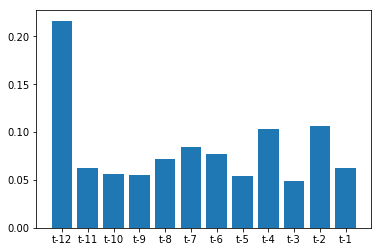

In [20]:
dataFrame = pd.read_csv('lags_12months_features.csv', header=0)
lagFeatures = dataFrame.values

# Split into inputs (X) and output (y)
X = lagFeatures[:, 0:-1]
y = lagFeatures[:, -1]

# Fit random forest model
# --> n_estimators: Number of trees
# --> random_state: Random generator seed
model = sklEN.RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)

print "Feature importance score:"
print model.feature_importances_

featureNames = dataFrame.columns.values[0:-1]
ticks = [i for i in range(len(featureNames))]

plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, featureNames)
plt.show()

## Feature Selection of Lag Variables

- We can also use feature selection to automatically identify and select those input features that are most predictive.

- A popular method for feature selection is called Recursive Feature Selection (RFE).

- RFE works by creating predictive models, weighting features, and pruning those with the smallest weights, then repeating the process until a desired number of features are left.

- The example below uses RFE with a random forest predictive model and sets the desired number of input features to 4.

Selected features:
t-12
t-6
t-4
t-2

Feature ranking score:
t-12  -->  1
t-11  -->  4
t-10  -->  6
t-9  -->  7
t-8  -->  3
t-7  -->  2
t-6  -->  1
t-5  -->  8
t-4  -->  1
t-3  -->  9
t-2  -->  1
t-1  -->  5


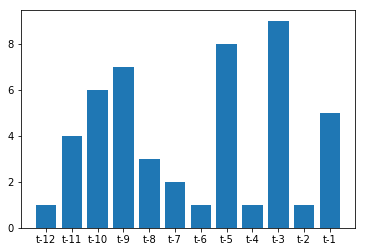

In [21]:
dataFrame = pd.read_csv('lags_12months_features.csv', header=0)
lagFeatures = dataFrame.values

# Split into inputs (X) and output (y)
X = lagFeatures[:, 0:-1]
y = lagFeatures[:, -1]

# Perform feature selection
# --> n_estimators: Number of trees
# --> random_state: Random generator seed
# --> n_features_to_select: Desired number of input features
rfe = sklFS.RFE(sklEN.RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=4)
fit = rfe.fit(X, y)

# Report selected features
print "Selected features:"
featureNames = dataFrame.columns.values[0:-1]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print featureNames[i]

# fit.ranking_ returns a list of feature importance measure,
# the lower the better
print "\nFeature ranking score:"
for i in range(len(fit.ranking_)):
    print featureNames[i], ' --> ', fit.ranking_[i]

ticks = [i for i in range(len(featureNames))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, featureNames)
plt.show()
